In [127]:
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import ast
from gensim.models import KeyedVectors
import nltk
import torch
from ast import literal_eval

In [74]:
def load_dataset():
    """
    Load training and test sets
    """
    train = pd.read_csv("./twitter_dataset/train.csv")
    dev = pd.read_csv("./twitter_dataset/dev.csv")
    
    return train, dev

In [79]:
def tokenizer(text: str):
    '''
    Citation: This tokenizer function & regex rule is borrowed from Katie's tokenizer regex demo at:
    https://www.cs.williams.edu/~kkeith/teaching/s23/cs375/attach/tokenization_regex_demo.html
    This helper function takes a string and returns a list of tokenized strings.
    '''
    regex = r"[A-Za-z]+|\$[\d\.]+|\S+" 
    res = nltk.regexp_tokenize(text, regex)
    return [i for i in res if i != "."]

In [197]:
def load_embeddings(filename):
    """
    Loads embeddings from embedding file and creates 
    1) dictionary of embedding words to indices
    2) list of embedding indices to words
    3) dense word embedding matrix
    """
    embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
    vocab2indx = dict(embeddings.key_to_index)
    idx2vocab = list(embeddings.index_to_key)
    embed_array = embeddings.vectors # matrix of dense word embeddings 
                                     # rows: a word 
                                     # columns: dimensions (50) of the dense embeddings
    return vocab2indx, idx2vocab, embed_array


def add_the_embedding(embed_array, vocab2indx): 
    """
    Adds "the" embedding to the embed_array matrix
    """
    the_embedding = embed_array[vocab2indx["the"]]
    out = np.vstack((embed_array, the_embedding))
    return out


def add_oov(idx2vocab, vocab2indx, embed_array):
    """
    Adds <OOV> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_oov_entry = len(embed_array)
    idx2vocab += ["<OOV>"]
    vocab2indx["<OOV>"] = new_oov_entry
    embed_array_w_oov = add_the_embedding(embed_array, vocab2indx)

    return idx2vocab, vocab2indx, embed_array_w_oov


def add_pad(idx2vocab, vocab2indx, embed_array):
    """
    Adds <PAD> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_pad_entry = len(embed_array)
    idx2vocab += ["<PAD>"]
    vocab2indx["<PAD>"] = new_pad_entry
    embed_array_w_pad = add_the_embedding(embed_array, vocab2indx)
    
    return idx2vocab, vocab2indx, embed_array_w_pad


def truncate(original_indices_list: list, maximum_length=100) -> list: 
    """
    Truncates the original_indices_list to the maximum_length
    """
    return original_indices_list[0:maximum_length]


def pad(original_indices_list: list, pad_index: int, maximum_length=100) -> list: 
    """
    Given original_indices_list, concatenates the pad_index enough times 
    to make the list to maximum_length. 
    """
    while len(original_indices_list) < maximum_length:
        original_indices_list.append(pad_index)
        
    return original_indices_list


def get_padded_oov_embeddings():
    """
    Get embedding array which includes the <PAD> and <OOV> tokens
    """
    vocab2indx, idx2vocab, embed_array = load_embeddings("glove50_4k.txt")
    idx2vocab, vocab2indx, embed_array_w_oov = add_oov(idx2vocab, vocab2indx, embed_array)
    idx2vocab, vocab2indx, embed_array_w_oov_pad = add_pad(idx2vocab, vocab2indx, embed_array_w_oov)
    
    return embed_array_w_oov_pad, vocab2indx, idx2vocab

def create_word_indices(tokens, vocab2indx): 
    """
    For each example, translate each token into its corresponding index from vocab2indx
    
    Replace words not in the vocabulary with the symbol "<OOV>" 
        which stands for 'out of vocabulary'
        
    Arguments: 
       - tokens (List[str]): list of strings of tokens 
       - vocab2indx (dict): each vocabulary word as strings and its corresponding int index 
                           for the embeddings 
                           
    Returns: 
        - (List[int]): list of integers
    """
    indices = []

    for token in tokens:
        if token not in vocab2indx:
            token = "<OOV>"
        indices.append(vocab2indx[token])
    
    return indices


def convert_X(Xmat):
    MAXIMUM_LENGTH = 32
    embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()
    
    X_list = []
    for one_train_example in Xmat:
        one_train_example = tokenizer(str(one_train_example))
        one_train_indices = create_word_indices(one_train_example, vocab2indx)
        one_train_indices = truncate(one_train_indices, maximum_length=MAXIMUM_LENGTH)
        one_train_indices = pad(one_train_indices, len(vocab2indx)-1, maximum_length=MAXIMUM_LENGTH)
        
        one_train_example_embeddings = [] # A list of token embeddings
        
        for index in one_train_indices:
            one_train_example_embeddings.append(embeddings[index])
        
        X_list.append(one_train_example_embeddings)
        
    X = torch.FloatTensor(X_list)
    return X

In [198]:
# INTEGRATION TEST, get_padded_oov_embeddings

embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()

len embed array:  4196
len embed array:  4197


In [199]:
train, dev = load_dataset()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [200]:
# Assuming we have train and test sets
Xmat_train = train["text"]
Y_train = train["Y_hard"]

Xmat_dev = dev["text"]
Y_dev = dev["Y_hard"]

In [201]:
X_train_embedded = convert_X(Xmat_train)
X_dev_embedded = convert_X(Xmat_dev)

len embed array:  4196
len embed array:  4197
len embed array:  4196
len embed array:  4197


In [202]:
def average_sentence_embedding(df):
    """
    Convert a tensor of shape (batch_size, num_sentences, embedding_size) to
    (batch_size, embedding_size) by averaging the embeddings along the second dimension.

    :param df: Input tensor with shape (batch_size, num_sentences, embedding_size)
    :type df: torch.Tensor
    :return: Averaged tensor with shape (batch_size, embedding_size)
    :rtype: torch.Tensor
    """
    # Check if the input is a PyTorch tensor
    if not isinstance(df, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    # Check if the input tensor has the correct shape
    if len(df.shape) != 3:
        raise ValueError("Input tensor must have 3 dimensions (batch_size, num_sentences, embedding_size).")

    # Compute the average along the second dimension (num_sentences)
    averaged_embeddings = df.mean(dim=1)

    return averaged_embeddings

In [203]:
Xmat_train = X_train_embedded # shape: (num_examples_test, 64, 50)
Xmat_dev = X_dev_embedded # shape: (num_examples_test, 64, 50)

# Average the word embeddings for each example into a sentence embedding
X_train_avg = average_sentence_embedding(Xmat_train) # shape: (num_examples_test, 50)
X_dev_avg = average_sentence_embedding(Xmat_dev) # shape: (num_examples_test, 50)

# Train a Logistic Regression model using the averaged embeddings
baseline_embed = LogisticRegression(max_iter=10000, multi_class='auto', solver='lbfgs')
baseline_embed.fit(X_train_avg, Y_train)

# Prediction & Evaluation
Y_pred_train = baseline_embed.predict(X_train_avg)
Y_pred_dev = baseline_embed.predict(X_dev_avg)

train_accuracy = accuracy_score(Y_train, Y_pred_train)
dev_accuracy = accuracy_score(Y_dev, Y_pred_dev)

print(f"Train accuracy: {train_accuracy}")
print(f"dev accuracy: {dev_accuracy}")


Train accuracy: 0.5286961946350592
dev accuracy: 0.5226197695573075


# Now, DAN:

In [206]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import nltk
import torch.nn.functional as F

In [207]:
def proba_to_label(proba_batch):
    # return 0, 1, 2
    
    # Detach the tensor and convert it to a NumPy array
    proba_batch_np = proba_batch.detach().numpy()

    # Find the index of the largest value in each sub-array
    max_indices = np.argmax(proba_batch_np, axis=1)

#     # Create a new array of the same shape filled with 0s
#     binary_array = np.zeros_like(proba_batch_np)

#     # Set the largest value positions to 1
#     for i, max_index in enumerate(max_indices):
#         binary_array[i, max_index] = 1

    return max_indices

In [208]:
# Build architecture

# Distilled Dual-task Deep Averaging Net
class DistilledDAN(nn.Module):
    """
    Pytorch implementation for Deep Averaging Network for classification 
    """
    
    def __init__(self, num_classes,
                       embedding_dim: int, 
                       hidden_dim1: int, 
                       hidden_dim2: int, 
                       leaky_relu_negative_slope: float, 
                       dropout_probability: float
                ):
        """
        Create the network architecture. 
        In our sentiment analysis, we have three classes: 0, 1, 2
        """
        
        super().__init__()
        self.num_classes = num_classes
        
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.leaky_relu_negative_slope = leaky_relu_negative_slope
        self.dropout_probability = dropout_probability
        
        self.hidden1 = nn.Linear(self.embedding_dim, self.hidden_dim1)
        self.hidden2 = nn.Linear(self.hidden_dim1,self.hidden_dim2)
        self.theta = nn.Linear(self.hidden_dim2, self.num_classes)
        
        self.log_softmax = nn.Softmax(dim=1) # A dimension along which LogSoftmax will be computed.
        self.apply_dropout = nn.Dropout(self.dropout_probability)
        
        
    def forward(self, x):
        """
        Define the forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor containing embedded word vectors.
                              Shape: (batch_size, sequence_length, embedding_dim)

        Returns:
            torch.Tensor: Log probability of each class. Shape: (batch_size, num_classes)
        """
        
        # Average the input word embeddings
        x = x.mean(dim=1)

        # Pass through the shared layers
        x = self.hidden1(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        x = self.hidden2(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        # Pass through final layer
        x = self.theta(x)

        # Apply the LogSoftmax activation function
        x = self.log_softmax(x)

        return x
    
    def train_model(self,
                    X_train,
                    Y_train,
                    X_dev,
                    Y_dev,
                    soft_labels,
                    optimizer,
                    num_iterations,
                    soft_label_weight=0.5,
                    loss_fn=nn.CrossEntropyLoss(),
                    batch_size=500,
                    check_every=10,
                    verbose=False):
        """
        Method to train the model. 

        soft_labels are only available for the training set. 
        """

        # Let the model know that we're in training mode, which is important for dropout
        self.train()

        loss_history = []
        train_accuracy = []
        dev_accuracy = []

        for t in range(num_iterations):
            if batch_size >= X_train.shape[0]: 
                X_batch = X_train
                Y_batch = Y_train
                soft_labels_batch = soft_labels
            else:
                batch_indices = np.random.randint(X_train.shape[0], size=batch_size)
                X_batch = X_train[batch_indices]
                Y_batch = Y_train[batch_indices]
                soft_labels_batch = soft_labels[batch_indices]

            # Forward pass 
            log_probs_batch = self.forward(X_batch)

            # Distillation loss (cross entropy loss with hard labels + cross entropy loss with soft labels)
            # weighted with soft and hard label
            loss = (1 - soft_label_weight) * loss_fn(log_probs_batch, Y_batch) + \
                    soft_label_weight * loss_fn(log_probs_batch, soft_labels_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % check_every == 0:
                loss_value = loss.item()
                loss_history.append(loss_value)

                # Check train accuracy (entire set, not just batch) 
                train_y_pred = self.predict(X_train)
                train_acc = self.accuracy(train_y_pred, Y_train.detach().numpy()) 
                train_accuracy.append(train_acc)

                # Check dev accuracy (entire set, not just batch) 
                dev_y_pred = self.predict(X_dev)
                dev_acc = self.accuracy(dev_y_pred, Y_dev.detach().numpy())
                dev_accuracy.append(dev_acc)

                if verbose: print(f"Iteration={t}, Loss={loss_value}")

        return loss_history, train_accuracy, dev_accuracy

    
    def predict(self, X, proba_mode=False):
        """
        Method to make predictions given a trained model. 
        
        No need to modify this method. 
        """
        self.eval()

        log_probs_batch = self.forward(X)

        if proba_mode:
            return log_probs_batch
        else:
            # Convert log probabilities to labels
            label_batch = proba_to_label(log_probs_batch)
            return label_batch
    
    @staticmethod
    def accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> float: 
        """
        Calculates accuracy. No need to modify this method. 
        """
        return np.mean(y_pred == y_true)

In [209]:
Y_train = train["label"]
Y_dev = dev["label"]

In [210]:
Y_soft_train = train["Y_soft"]

In [211]:
# Convert string representation to actual list
# Y_train = np.array([literal_eval(row) for row in Y_train])

In [212]:
# Y_dev = np.array([literal_eval(row) for row in Y_dev])

In [213]:
Y_soft_train = np.array([literal_eval(row) for row in Y_soft_train])

/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_91925/940148988.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(Xmat_train, dtype=torch.float32)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_91925/940148988.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.long)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_91925/940148988.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
/var/

Iteration=0, Loss=1.1017506122589111
Iteration=10, Loss=1.092753529548645
Iteration=20, Loss=1.0968109369277954
Iteration=30, Loss=1.0909374952316284
Iteration=40, Loss=1.096466302871704
Iteration=50, Loss=1.0929478406906128
Iteration=60, Loss=1.0836760997772217
Iteration=70, Loss=1.0869009494781494
Iteration=80, Loss=1.0887317657470703
Iteration=90, Loss=1.0879688262939453
Iteration=100, Loss=1.0862741470336914
Iteration=110, Loss=1.0853545665740967
Iteration=120, Loss=1.0740911960601807
Iteration=130, Loss=1.0694680213928223
Iteration=140, Loss=1.0631929636001587
Iteration=150, Loss=1.0696110725402832
Iteration=160, Loss=1.0580575466156006
Iteration=170, Loss=1.0528252124786377
Iteration=180, Loss=1.0599355697631836
Iteration=190, Loss=1.0434296131134033
Iteration=200, Loss=1.0557317733764648
Iteration=210, Loss=1.0487086772918701
Iteration=220, Loss=1.0451431274414062
Iteration=230, Loss=1.0524680614471436
Iteration=240, Loss=1.0639723539352417
Iteration=250, Loss=1.041700839996338


Iteration=2110, Loss=0.9860596656799316
Iteration=2120, Loss=1.008072853088379
Iteration=2130, Loss=0.9991500973701477
Iteration=2140, Loss=0.989987850189209
Iteration=2150, Loss=0.9725174903869629
Iteration=2160, Loss=1.0009082555770874
Iteration=2170, Loss=1.017545461654663
Iteration=2180, Loss=0.9980241060256958
Iteration=2190, Loss=0.9710147380828857
Iteration=2200, Loss=1.0052285194396973
Iteration=2210, Loss=1.0120809078216553
Iteration=2220, Loss=1.006948709487915
Iteration=2230, Loss=0.9872822761535645
Iteration=2240, Loss=0.9976683855056763
Iteration=2250, Loss=1.0025508403778076
Iteration=2260, Loss=0.9956897497177124
Iteration=2270, Loss=1.000295639038086
Iteration=2280, Loss=1.0124108791351318
Iteration=2290, Loss=1.0094690322875977
Iteration=2300, Loss=1.0037176609039307
Iteration=2310, Loss=0.9771761894226074
Iteration=2320, Loss=1.0085257291793823
Iteration=2330, Loss=1.0164285898208618
Iteration=2340, Loss=1.0121387243270874
Iteration=2350, Loss=0.995577335357666
Iterat

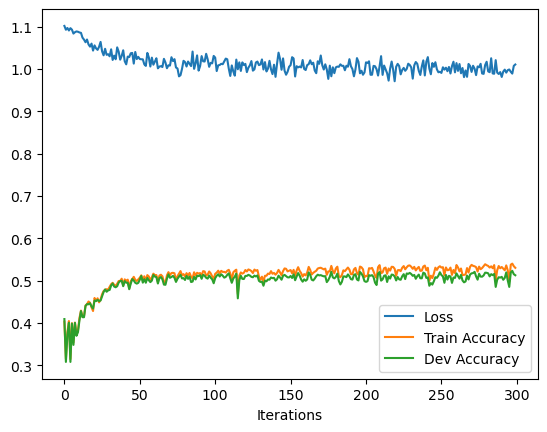

In [225]:
# Step 1: Load and preprocess your dataset
X_train = torch.tensor(Xmat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
soft_labels = torch.tensor(Y_soft_train, dtype=torch.float32)

# Step 2: Create an instance of the DistilledDAN model
num_classes = 3
embedding_dim = 50
hidden_dim1 = 64
hidden_dim2 = 32
leaky_relu_negative_slope = 0.01
dropout_probability = 0.5

model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, leaky_relu_negative_slope, dropout_probability)

# Step 3: Train the model using the `train_model` method
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_iterations = 3000
soft_label_weight = 0.5
loss_fn = nn.CrossEntropyLoss()
batch_size = 500
check_every = 10
verbose = True

loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)

# Plot the training progress
import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(dev_accuracy, label='Dev Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [226]:
dev_accuracy[-1]

0.5124317768344451

In [215]:
loss_fn(log_probs_batch, Y_batch)

tensor(1.1736, grad_fn=<NllLossBackward0>)

In [216]:
Y_batch = Y_train[0:10]

In [221]:
Y_batch

tensor([2, 0, 2, 1, 1, 1, 0, 1, 2, 2])

In [217]:
X_train_batch = X_train[0:10]

In [224]:
log_probs_batch

tensor([[7.1934e-02, 6.1714e-01, 3.1093e-01],
        [9.8872e-01, 1.1055e-02, 2.2412e-04],
        [1.7298e-01, 6.5338e-01, 1.7364e-01],
        [1.1245e-01, 3.8945e-01, 4.9810e-01],
        [2.7214e-03, 3.2602e-02, 9.6468e-01],
        [2.4449e-03, 3.8288e-02, 9.5927e-01],
        [2.5882e-02, 7.8515e-01, 1.8897e-01],
        [8.7644e-02, 1.9495e-01, 7.1741e-01],
        [1.2847e-02, 9.6496e-01, 2.2194e-02],
        [1.5724e-02, 1.2912e-02, 9.7136e-01]], grad_fn=<SoftmaxBackward0>)

In [218]:
log_probs_batch = model.forward(X_train_batch)

In [219]:
loss_fn(log_probs_batch, Y_batch)

tensor(1.1875, grad_fn=<NllLossBackward0>)

In [220]:
# Sample input and target tensors
logits = torch.tensor([[0.5, 1.0, 1.5], [1.0, 0.5, 1.5]], dtype=torch.float32)
targets = torch.tensor([0, 0], dtype=torch.long)

# Create the cross-entropy loss object
loss_fn = nn.CrossEntropyLoss()

# Compute the loss
loss = loss_fn(logits, targets)

print(f"Cross-entropy loss: {loss.item()}")

Cross-entropy loss: 1.430269718170166


In [144]:
# Sample one-hot encoded labels tensor
Y_batch_one_hot = torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=torch.float32)

# Convert one-hot encoded labels to class indices
Y_batch_indices = torch.argmax(Y_batch_one_hot, dim=1)

print(Y_batch_indices)

tensor([2, 0, 1])
